https://www.kaggle.com/jeanmidev/smart-meters-in-london

# Project 2 - Predicting Energy Output of London Homes. 

### Part 3 - Modelling
1. Data Exploration
1. Initial Data Modeling
1. Finalize Data Model
1. Data Evaluation


In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics

pd.set_option('display.max_rows', 500)
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

## 1. Data Exploration
### Conclusions: 
* Temperature and Energy follow an inverse relationship
* Wind Speed and Presure appear to be non-factors
* Energy Use appears to be related to the wealth of a neighborhood
* Energy Use on weekends are higher than weekdays

In [2]:
df = pd.read_pickle('Data/Final_Dataset.pkl')
df = df.dropna()

In [3]:
df['Exp_Value_Beds']=pd.to_numeric(df['Exp_Value_Beds'])
df['Exp_Value_People']=pd.to_numeric(df['Exp_Value_People'])

In [267]:
grouped_df = df.groupby('Date').mean().reset_index()

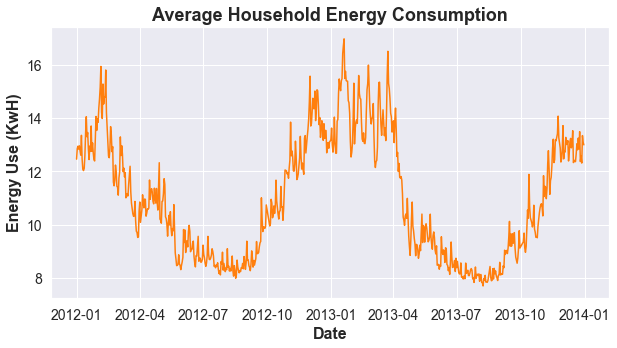

In [385]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(grouped_df['Date'], grouped_df['daily_energy(KwH)'], color = 'tab:orange')
ax1.set_ylabel('Energy Use (KwH)', fontweight='bold', fontsize=16)
ax1.set_xlabel('Date', fontweight='bold', fontsize=16)
plt.title('Average Household Energy Consumption', fontsize = 18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.axes_style("darkgrid")
plt.show()

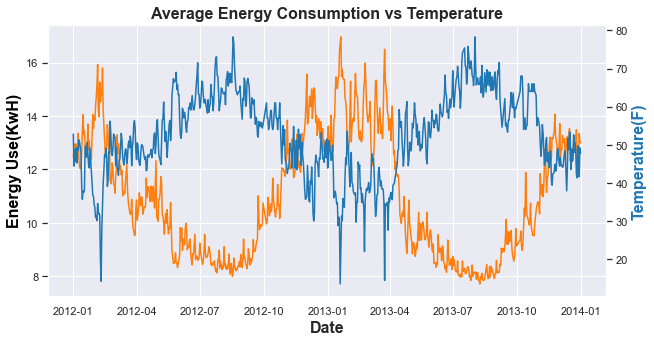

In [373]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(grouped_df['Date'], grouped_df['daily_energy(KwH)'], color = 'tab:orange')
ax1.set_ylabel('Energy Use(KwH)', fontweight='bold', color = 'black', fontsize='16')
ax1.set_xlabel('Date', fontweight='bold', fontsize='16')
ax2 = ax1.twinx()
ax2.plot(grouped_df['Date'], grouped_df['Temperature(F)'],color = 'tab:blue')
ax2.set_ylabel('Temperature(F)',fontweight='bold',color = 'tab:blue', fontsize='16')
plt.title('Average Energy Consumption vs Temperature', fontsize = 16, fontweight='bold')
plt.grid()
plt.show()

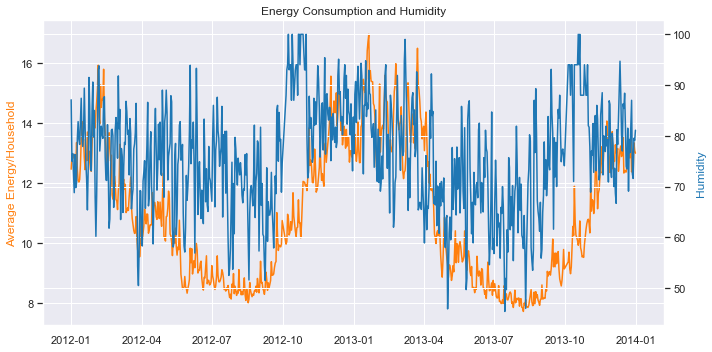

In [374]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(grouped_df['Date'], grouped_df['daily_energy(KwH)'], color = 'tab:orange')
ax1.set_ylabel('Average Energy/Household',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(grouped_df['Date'], grouped_df['Humidity(%)'],color = 'tab:blue')
ax2.set_ylabel('Humidity',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

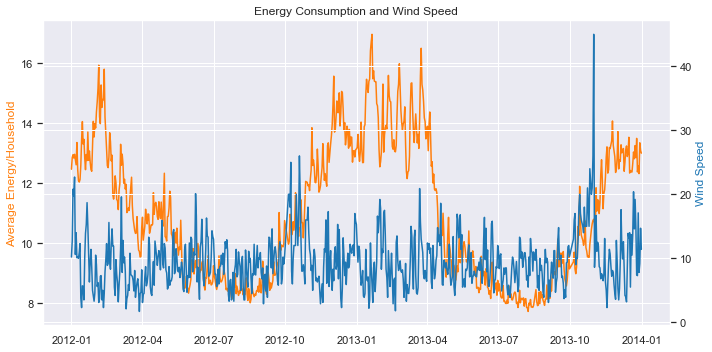

In [375]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(grouped_df['Date'], grouped_df['daily_energy(KwH)'], color = 'tab:orange')
ax1.set_ylabel('Average Energy/Household',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(grouped_df['Date'], grouped_df['Wind_Speed(mph)'],color = 'tab:blue')
ax2.set_ylabel('Wind Speed',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

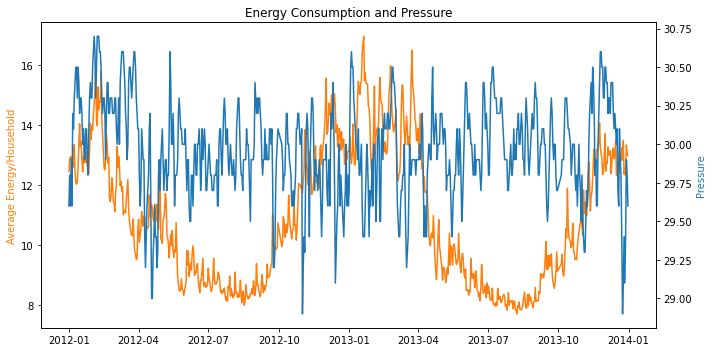

In [231]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(grouped_df['Date'], grouped_df['daily_energy(KwH)'], color = 'tab:orange')
ax1.set_ylabel('Average Energy/Household',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(grouped_df['Date'], grouped_df['Pressure(Hg)'],color = 'tab:blue')
ax2.set_ylabel('Pressure',color = 'tab:blue')
plt.title('Energy Consumption and Pressure')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(grouped_df['Date'], grouped_df['daily_energy(KwH)'], color = 'tab:orange')
ax1.set_ylabel('Average Energy/Household',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(grouped_df['Date'], grouped_df['Pressure(Hg)'],color = 'tab:blue')
ax2.set_ylabel('Pressure',color = 'tab:blue')
plt.title('Energy Consumption and Pressure')
fig.tight_layout()
plt.show()

<AxesSubplot:>

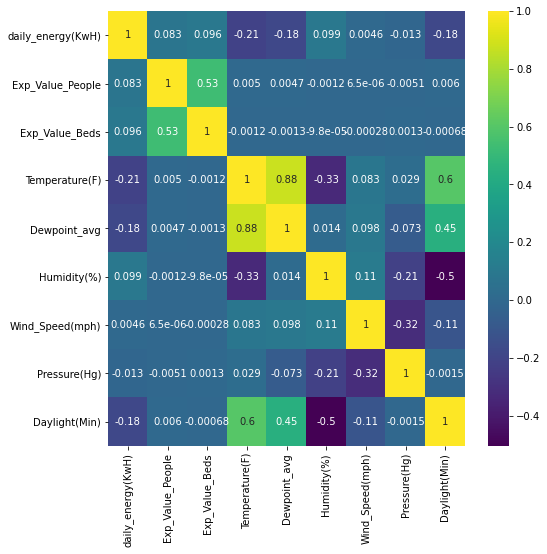

In [338]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

Text(0, 0.5, 'Daily Energy(KwH)')

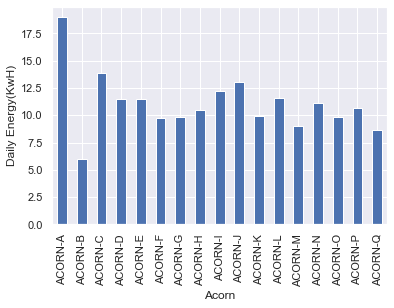

In [376]:
df.groupby('Acorn')['daily_energy(KwH)'].mean().plot.bar()
plt.ylabel('Daily Energy(KwH)')

(9.0, 12.0)

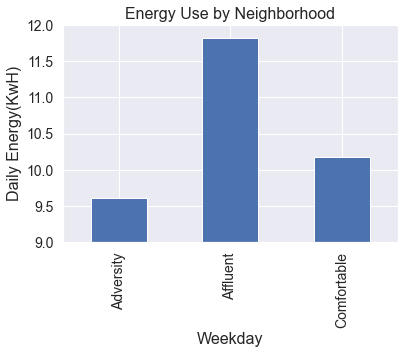

In [377]:
df.groupby('Acorn_grouped')['daily_energy(KwH)'].mean().plot.bar()
plt.ylabel('Daily Energy(KwH)', fontsize=16)
plt.title('Energy Use by Neighborhood', fontsize=16)
plt.xlabel('Weekday', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(9, 12)

(9.0, 12.0)

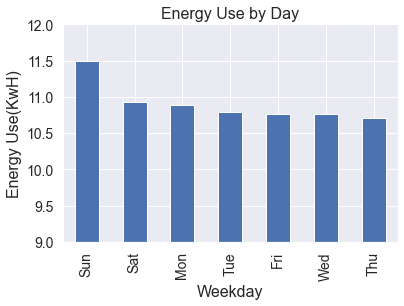

In [378]:
df.groupby('Weekday')['daily_energy(KwH)'].mean().sort_values(ascending=False).plot.bar()
plt.ylabel('Energy Use(KwH)', fontsize=16)
plt.title('Energy Use by Day', fontsize=16)
plt.xlabel('Weekday', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(9, 12)

In [368]:
df.groupby('Weekday')['daily_energy(KwH)'].mean().sort_values(ascending=False)

Weekday
Sun    11.494363
Sat    10.927933
Mon    10.887431
Tue    10.792362
Fri    10.758814
Wed    10.758388
Thu    10.713571
Name: daily_energy(KwH), dtype: float64

## 2. Initial Data Modeling

## Build the commonly used Functions

In [10]:
def build_model(x_train, y_train, dfX):
    """Objective: 
    Output the Linear Regression model and the list of variables with coefficients
    """
    lm = LinearRegression()
    model = lm.fit(x_train, y_train)
    variables = dfX.columns 
    print(list(zip(variables, model.coef_)))
    return model
    
def test_model(model, x_train, x_test, y_train, y_test):
    """Objective: 
    1. Outputs the scores of the Training and Test
    2. Outputs the Plots of Prediction vs. Actual values 
    3. Outputs the Residual Plots
    """
    
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
    print ('Training Score:', model.score(x_train, y_train)) 
    print ('Test Score:', model.score(x_test, y_test)) 
    print ('MAE:', metrics.mean_absolute_error(y_test, pred_test))

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Results for this Model',fontsize = 16, fontweight='bold')

    ax[0][0].scatter(y_test , pred_test, alpha=0.5, s=1) 
    ax[0][0].set_title('Test: Predictions vs Actual Values', fontweight='bold')
    ax[0][0].set_xlabel('Actual Value - Daily Energy(KwH)')
    ax[0][0].set_ylabel('Predicted Value - Daily Energy(KwH)')

    ax[0][1].scatter(y_train, pred_train, alpha=0.5, s=1) 
    ax[0][1].set_title('Training: Predictions vs Actual Values', fontweight='bold')
    ax[0][1].set_xlabel('Actual Value - Daily Energy(KwH)')
    ax[0][1].set_ylabel('Predicted Value - Daily Energy(KwH)')


    ax[1][0].scatter(pred_test, abs(y_test - pred_test), alpha=0.5, s=1) 
    ax[1][0].set_title('Residuals: Testing Data', fontweight='bold')
    ax[1][0].set_xlabel('Predicted Value - Daily Energy(KwH)')
    ax[1][0].set_ylabel('Residuals - Daily Energy(KwH)')

    
    ax[1][1] = sns.histplot((y_test - pred_test)) 
    ax[1][1].set_title('Residuals: Distribution of Residuals', fontweight='bold')
    ax[1][1].set_xlabel('Predicted Value - Daily Energy(KwH)')
    ax[1][1].set_ylabel('Count')
    ax[1][1].set_xlim([-50, 50])


## Iteration 1- Only looking at Numerical Columns
#### Observations
* Model looks very bad at moment

In [269]:
df.columns

Index(['LCLid', 'Date', 'daily_energy(KwH)', 'Acorn', 'Acorn_grouped',
       'Exp_Value_People', 'Exp_Value_Beds', 'Temperature(F)', 'Dewpoint_avg',
       'Humidity(%)', 'Wind_Speed(mph)', 'Pressure(Hg)', 'Daylight(Min)',
       'Weekday', 'Day_Type'],
      dtype='object')

In [270]:
vars1 = ['Exp_Value_People', 'Exp_Value_Beds', 'Temperature(F)', 'Dewpoint_avg',
       'Humidity(%)', 'Wind_Speed(mph)', 'Pressure(Hg)', 'Daylight(Min)']
y1 = df['daily_energy(KwH)']
X1 = df[vars1]

In [271]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=10)


In [272]:
a = build_model(X1_train, y1_train, X1)

[('Exp_Value_People', 1.6822627635402607), ('Exp_Value_Beds', 1.1580366678231473), ('Temperature(F)', -0.11859545540355879), ('Dewpoint_avg', -0.02393774575781922), ('Humidity(%)', 0.011278409383109096), ('Wind_Speed(mph)', 0.01370634868753376), ('Pressure(Hg)', -0.2358939255880285), ('Daylight(Min)', -0.004463812571143144)]


Training Score: 0.05865125884818012
Test Score: 0.058574773163699745
MAE: 6.290592490251666


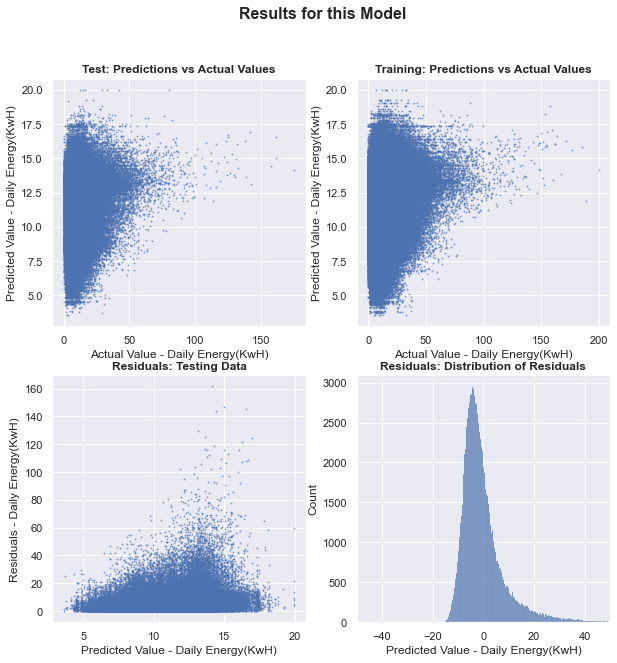

In [379]:
test_model(a, X1_train, X1_test, y1_train, y1_test)

## Iteration 2- Include the Dummy Variables to see if it improves
#### Observations
* Marginal Improvement in the model


In [5]:
ac_grouped_dummies = pd.get_dummies(df['Acorn_grouped'])
ac_dummies = pd.get_dummies(df['Acorn'])
day_dummies = pd.get_dummies(df['Weekday'])
df2 = pd.concat([df, ac_grouped_dummies, ac_dummies, day_dummies], axis=1)
df2.head()

,LCLid,Date,daily_energy(KwH),Acorn,Acorn_grouped,Exp_Value_People,Exp_Value_Beds,Temperature(F),Dewpoint_avg,Humidity(%),...,ACORN-O,ACORN-P,ACORN-Q,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,MAC000015,2012-01-01,6.327,ACORN-E,Affluent,3.090331,3.091146,52.8,48.8,87.1,...,0,0,0,0,0,0,1,0,0,0
2,MAC000017,2012-01-01,5.635,ACORN-C,Affluent,2.700542,3.759579,52.8,48.8,87.1,...,0,0,0,0,0,0,1,0,0,0
3,MAC000018,2012-01-01,7.875,ACORN-E,Affluent,3.090331,3.091146,52.8,48.8,87.1,...,0,0,0,0,0,0,1,0,0,0
4,MAC000019,2012-01-01,6.594,ACORN-K,Adversity,3.391304,3.485459,52.8,48.8,87.1,...,0,0,0,0,0,0,1,0,0,0
5,MAC000020,2012-01-01,14.949,ACORN-J,Comfortable,2.914021,3.108295,52.8,48.8,87.1,...,0,0,0,0,0,0,1,0,0,0


In [6]:
vars2 = ['Exp_Value_People', 'Exp_Value_Beds', 'Temperature(F)', 
       'Humidity(%)', 'Wind_Speed(mph)', 'Pressure(Hg)',
       'Daylight(Min)', 'Adversity', 'Affluent',
       'ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D', 'ACORN-E',
       'ACORN-F', 'ACORN-G', 'ACORN-H', 'ACORN-I', 'ACORN-J', 'ACORN-K',
       'ACORN-L', 'ACORN-M', 'ACORN-N', 'ACORN-O', 'ACORN-P', 'Fri',
       'Mon', 'Sat', 'Sun', 'Thu', 'Tue']
X2 = df2[vars2]
y2 = df2['daily_energy(KwH)']


In [7]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=10)

In [11]:
b = build_model(X2_train, y2_train, X2)

[('Exp_Value_People', 744441085.8557973), ('Exp_Value_Beds', -306995788.7165782), ('Temperature(F)', -0.1408144036866052), ('Humidity(%)', 0.0034612792060335186), ('Wind_Speed(mph)', 0.01445893867452491), ('Pressure(Hg)', -0.2100816149683989), ('Daylight(Min)', -0.0045607348980719765), ('Adversity', -204701881.8784065), ('Affluent', -7740103.161422593), ('ACORN-A', 81412599.88796437), ('ACORN-B', 40226244.84537846), ('ACORN-C', 290947224.2542435), ('ACORN-D', -215892581.7527711), ('ACORN-E', -204433590.3962323), ('ACORN-F', 173769839.79032457), ('ACORN-G', -85050574.6706534), ('ACORN-H', -159994815.22715068), ('ACORN-I', 359374397.86838603), ('ACORN-J', -75656862.7210764), ('ACORN-K', -110476533.60247461), ('ACORN-L', -37288632.598039396), ('ACORN-M', -124429764.5963142), ('ACORN-N', 258303927.99305576), ('ACORN-O', 82141793.91955431), ('ACORN-P', -520539719.55775565), ('Fri', -0.030823010645690374), ('Mon', 0.07549564032524358), ('Sat', 0.039735846570692956), ('Sun', 0.583912169136056

Training Score: 0.07786965550195091
Test Score: 0.07801440147776406
MAE: 6.239333155565602


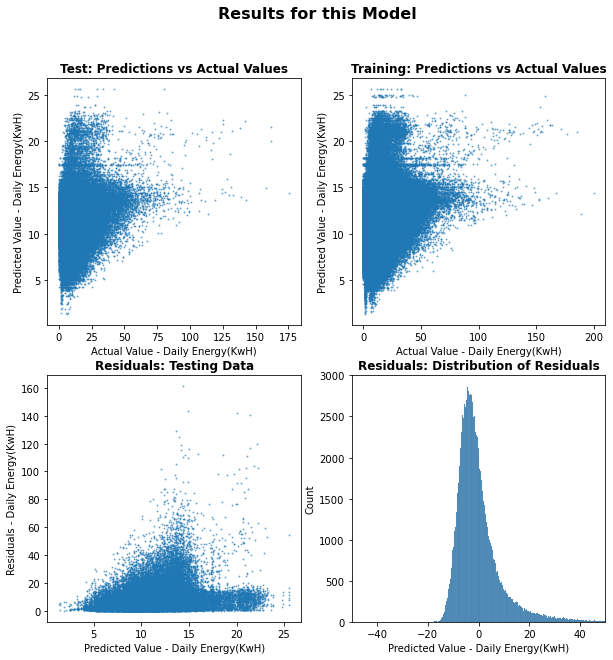

In [12]:
test_model(b, X2_train, X2_test, y2_train, y2_test)

## Now What? Implement a Shifted Parameter

Given that all the usable parameters are not giving any sort of reasonable estimation of energy usage, I need to look at how else I can use the available features.  
Home energy usage is a very difficult thing to predict using these parameters as there are so many factors that affect this.  For example, a big home in an affluent neighborhood may use Solar Panels, while a small home in an adverse neighborhood may have very bad insulation. 
### Moving Forward: 
Create a new column which is a shifted column of the previous day's energy for a given home.  This will turn the problem into a time series analysis and should greatly improve the model performance and it will be better at predicting the energy usage for a single home

In [13]:
# Create the shifted column
df_shift = df2.copy()
df_shift['shifted'] = df_shift.groupby('LCLid')['daily_energy(KwH)'].shift(1)
df_shift = df_shift.dropna()
df_shift.head()

,LCLid,Date,daily_energy(KwH),Acorn,Acorn_grouped,Exp_Value_People,Exp_Value_Beds,Temperature(F),Dewpoint_avg,Humidity(%),...,ACORN-P,ACORN-Q,Fri,Mon,Sat,Sun,Thu,Tue,Wed,shifted
411,MAC000015,2012-01-02,6.601,ACORN-E,Affluent,3.090331,3.091146,44.4,36.7,75.0,...,0,0,0,1,0,0,0,0,0,6.327
413,MAC000017,2012-01-02,6.863,ACORN-C,Affluent,2.700542,3.759579,44.4,36.7,75.0,...,0,0,0,1,0,0,0,0,0,5.635
414,MAC000018,2012-01-02,11.055,ACORN-E,Affluent,3.090331,3.091146,44.4,36.7,75.0,...,0,0,0,1,0,0,0,0,0,7.875
415,MAC000019,2012-01-02,8.652,ACORN-K,Adversity,3.391304,3.485459,44.4,36.7,75.0,...,0,0,0,1,0,0,0,0,0,6.594
416,MAC000020,2012-01-02,7.643,ACORN-J,Comfortable,2.914021,3.108295,44.4,36.7,75.0,...,0,0,0,1,0,0,0,0,0,14.949


In [29]:
#Create a 50-25-25 Non-Random Split to build and validate the models
training, validation, test = np.split(df_shift.sample(frac=1), [int(.5*len(df_shift)), int(.75*len(df_shift))])

## Iteration 4- Using all parameters including new shifted columns
* Dramatic increase in the model performance

In [30]:
vars4 = ['Exp_Value_People', 'Exp_Value_Beds', 'Temperature(F)', 
       'Humidity(%)', 'Wind_Speed(mph)', 'Pressure(Hg)',
       'Daylight(Min)', 'Adversity', 'Affluent',
       'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Fri','shifted']
X4 = df_shift[vars4]
y4 = df_shift['daily_energy(KwH)']

X4_train = training[vars4]
X4_test = test[vars4]
X4_valid = validation[vars4]

y4_train = training['daily_energy(KwH)']
y4_test = test['daily_energy(KwH)']
y4_valid = validation['daily_energy(KwH)']

In [31]:
d = build_model(X4_train, y4_train, X4)

[('Exp_Value_People', 0.0028851186160974663), ('Exp_Value_Beds', 0.16849480931786998), ('Temperature(F)', -0.01590444805785419), ('Humidity(%)', 0.00816514676980721), ('Wind_Speed(mph)', 0.006444446016543641), ('Pressure(Hg)', 0.010236439034574912), ('Daylight(Min)', -0.00016801733347709957), ('Adversity', 0.16302286292634238), ('Affluent', 0.21338767471129727), ('Mon', -0.4534801325072197), ('Sat', 0.2078442492091538), ('Sun', 0.5884523341980911), ('Thu', 0.004333249160752419), ('Tue', -0.05914504604212504), ('Fri', 0.08322046023633328), ('shifted', 0.9087420103465885)]


Training Score: 0.8401707075782283
Test Score: 0.8397458722968847
MAE: 2.382044491344535


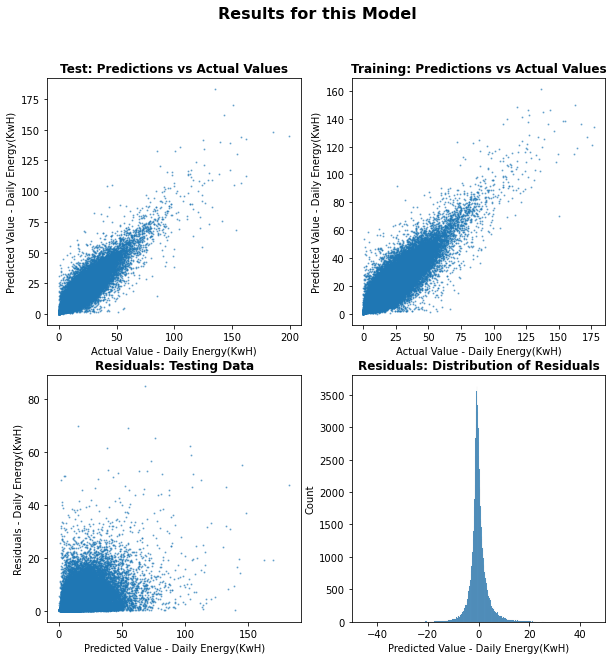

In [32]:
test_model(d, X4_train, X4_test, y4_train, y4_test)

## 3. Model Evaluation
### Measure Feature Importance to see what variables I can remove from the model
* Now that the model looks much better, I will use Lasso and Statsmodel summary to verify if any features can be removed from the model

In [33]:
# Stats Model
X5=df_shift[['Exp_Value_People', 'Exp_Value_Beds', 'Temperature(F)', 
       'Humidity(%)', 'Wind_Speed(mph)', 'Pressure(Hg)',
       'Daylight(Min)', 'Adversity', 'Affluent',
       'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Fri','shifted']]
X5=sm.add_constant(X5)
model = sm.OLS(df_shift['daily_energy(KwH)'], X5.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      daily_energy(KwH)   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                 1.794e+05
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:45:31   Log-Likelihood:            -1.5325e+06
No. Observations:              550445   AIC:                         3.065e+06
Df Residuals:                  550428   BIC:                         3.065e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9910      0.589      1.683      0.092      -0.163       2.145
Exp_Value_People    -0.0570      0.028     -2.012      0.044      -0.112      -0.001
Exp_Value_Beds       0.2209      0.017     13.088      0.000       0.188       0.254
Temperature(F)      -0.0173      0.001    -27.429      0.000      -0.019      -0.016
Humidity(%)          0.0070      0.001     11.941      0.000       0.006       0.008
Wind_Speed(mph)      0.0066      0.001      4.838      0.000       0.004       0.009
Pressure(Hg)        -0.0104      0.019     -0.552      0.581      -0.047       0.027
Daylight(Min)       -0.0001   4.15e-05     -3.299      0.001      -0.000   -5.55e-05
Adversity            0.2226      0.025      8.804      0.000       0.173       0.272
Affluent             0.2539      0.017     14.938      0.000       0.221       0.287
Mon                 -0.4873      0.020    -24.543      0.000      -0.526      -0.448
Sat                  0.1986      0.020     10.017      0.000       0.160       0.237
Sun                  0.5655      0.020     28.514      0.000       0.527       0.604
Thu                 -0.0172      0.020     -0.865      0.387      -0.056       0.022
Tue                 -0.0774      0.020     -3.887      0.000      -0.116      -0.038
Fri                  0.0617      0.020      3.107      0.002       0.023       0.101
shifted              0.9088      0.001   1624.755      0.000       0.908       0.910
==============================================================================
Omnibus:                   198544.624   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7565122.593
Skew:                           1.057   Prob(JB):                         0.00
Kurtosis:                      21.038   Cond. No.                     8.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Using Lasso
model5 = LassoCV()
s = StandardScaler()
x_train_scaled = s.fit_transform(X4_train)
model5.fit(x_train_scaled, y4_train)
model5.score(x_train_scaled, y4_train)

0.840150555380188

In [35]:
print('LassoCV score:', model5.score(x_train_scaled, y4_train))
print('LassoCV Optimal Alpha:', model5.alpha_)
print('Lasso Modeling Coefficients:')
list(zip(X4_train.columns, model5.coef_))

LassoCV score: 0.840150555380188
LassoCV Optimal Alpha: 0.008916921957707786
Lasso Modeling Coefficients:


[('Exp_Value_People', 0.01987319426944808),
 ('Exp_Value_Beds', 0.04492152439655407),
 ('Temperature(F)', -0.16641953251652933),
 ('Humidity(%)', 0.08128527496781729),
 ('Wind_Speed(mph)', 0.0179762545283669),
 ('Pressure(Hg)', -0.0),
 ('Daylight(Min)', -0.02989065487350543),
 ('Adversity', 0.0),
 ('Affluent', 0.059576049519338946),
 ('Mon', -0.1557020470335762),
 ('Sat', 0.061262001962928456),
 ('Sun', 0.19459793217086677),
 ('Thu', -0.0),
 ('Tue', -0.018199672905679226),
 ('Fri', 0.01684222966494449),
 ('shifted', 8.853122532416267)]

### Conclusions from statsmodel and LassoCV
* Both show that there is little confidence that Exp_Value_People, Pressure, and the day Thursday has any affect on the model. 
* Alpha value in LassoCV is very small(.009) which essentially means that the coefficients obtained from standard Linear Regression are essentially the same
* Key parameters are Temperature, Affluence, Sunday and # of beds 

# Iteration 6: Final Model

In [36]:
vars6 = ['Exp_Value_Beds', 'Temperature(F)', 
       'Humidity(%)', 'Wind_Speed(mph)', 
       'Daylight(Min)', 'Adversity', 'Affluent',
       'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Fri','shifted']
X6 = df_shift[vars6]
y6 = df_shift['daily_energy(KwH)']

X6_train = training[vars6]
X6_test = test[vars6]
X6_valid = validation[vars6]

y6_train = training['daily_energy(KwH)']
y6_test = test['daily_energy(KwH)']
y6_valid = validation['daily_energy(KwH)']

In [37]:
f = build_model(X6_train, y6_train, X6)

[('Exp_Value_Beds', 0.16963002309987354), ('Temperature(F)', -0.015871167065172664), ('Humidity(%)', 0.008090528256093918), ('Wind_Speed(mph)', 0.0062027153679660735), ('Daylight(Min)', -0.00017212990843881726), ('Adversity', 0.164258474776359), ('Affluent', 0.21427863904064093), ('Mon', -0.45350824302584714), ('Sat', 0.2079494336513489), ('Sun', 0.588575908699464), ('Thu', 0.004300873231142221), ('Tue', -0.059420795436897655), ('Fri', 0.08320558980579452), ('shifted', 0.9087395154381003)]


Training Score: 0.8401706179435547
Test Score: 0.8397469834609609
MAE: 2.382039235809937


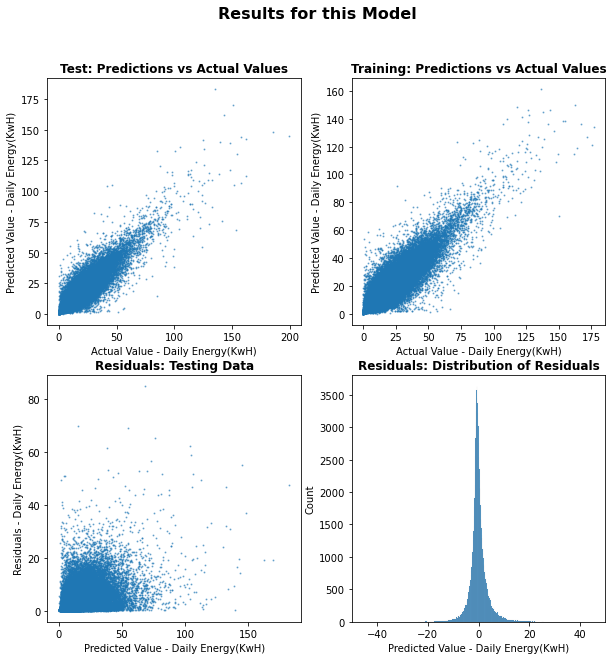

In [38]:
test_model(f, X6_train, X6_test, y6_train, y6_test)

### Conclusions on the final model: 
* The final model does a good job predicting home energy usage
* Residuals are normally distributed